In [2]:
! pip install --quiet  "urllib3" "seaborn"

In [1]:
import sys  
sys.path.insert(0, r"C:\\Users\jorge\\Documents\\Projects Jorge C\\DRUIDA PROJECT\\POC\\druida_V01\\src\\")

import os

from __future__ import print_function
#from Utilities.SaveAnimation import Video



from druida import Stack
from druida import setup

from druida.DataManager import datamanager
from druidaHFSS.modules import tools
from druida.tools import utils


#import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

from torchvision import transforms

import glob
from tqdm.notebook import tqdm
import random
import numpy as np
import pandas as pd

import argparse


plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/VisionTransformers/")

# Setting the seed
#L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


<Figure size 640x480 with 0 Axes>

In [2]:
boxImagesPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images Jorge Cardenas\\"
DataPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Exports\\output\\"
simulationData="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\DBfiles\\"

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument("run_name",type=str)
parser.add_argument("epochs",type=int)
parser.add_argument("batch_size",type=int)
parser.add_argument("workers",type=int)
parser.add_argument("gpu_number",type=int)
parser.add_argument("device",type=str)
parser.add_argument("learning_rate",type=float)
parser.add_argument("condition_len",type=float) #This defines the length of our conditioning vector
parser.add_argument("metricType",type=float) #This defines the length of our conditioning vector
parser.add_argument("patch_size",type=int)

parser.run_name = "Predictor Training"
parser.epochs = 1
parser.batch_size = 10
parser.workers=0
parser.gpu_number=0
parser.image_size = 128
parser.dataset_path = os.path.normpath('/content/drive/MyDrive/Training_Data/Training_lite/')
parser.device = "cpu"
parser.learning_rate = 3e-4
parser.condition_len = 10
parser.metricType='AbsorbanceTM' #this is to be modified when training for different metrics.
parser.patch_size=16

metricType=['AbsorbanceTM','AbsorbanceTE' ]

categories=["box", "circle", "cross"]

model_kwargs={
        "batch_size":parser.batch_size,
        "embed_dim":  3 * parser.patch_size**2 ,
        "hidden_dim":  2*(3 * parser.patch_size**2),
        "num_heads": 16,
        "num_layers": 8,
        "patch_size": parser.patch_size,
        "num_channels": 3,
        "num_patches": (parser.image_size//parser.patch_size)**2,
        "num_classes": 601,
        "dropout": 0.1,
    }





In [4]:
dataloader = utils.get_data_with_labels(128, 128,0.95, boxImagesPath,parser.batch_size, drop_last=True)


## 1. Preprocessing

In [5]:
imagesPath="C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\"

In [8]:

folders=glob.glob(imagesPath+"/*/", recursive = True)
files=[]

print(folders)
for folder in folders:
    
    if folder != imagesPath+"\\"+ "processed128\\":
        files=(files+glob.glob(folder+"/*"))



['C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\09a2f2c2-ad7f-11ee-bb2a-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\0ed3a0e8-a653-11ee-9db6-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\3be7fd33-bd16-11ee-be43-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\55628454-b316-11ee-82a4-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\56dee422-b317-11ee-bb58-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\7262ded2-a81d-11ee-8e0e-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\89962313-bbc8-11ee-a7fe-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\a03ae6f6-bc71-11ee-aef0-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\b34769e8-bcbb-11ee-bce8-047c16a08772\\', 'C:\\Users\\jorge\\Dropbox\\Public\\MetasufacesData\\Images\\b6b02fee-a8bb-11ee-8

In [9]:

for file in files:
    fileName_absolute = os.path.basename(file) 
    path=os.path.dirname(file)

    #ROI is 
    image_rgb=tools.cropImage( file,image_path=path,
                              image_name=fileName_absolute,
                              output_path=imagesPath, 
                             resize_dim=(128,128))
        


## Architecture

In [5]:

vision_transformer = Stack.VisionTransformer(**model_kwargs )


### just in case a unit test is needed

In [8]:

# compute vision transformer output
vit_output = vision_transformer(images)

assert vit_output.size(dim=1) == 601
print(vit_output.shape)

# get class probabilities
probabilities = F.softmax(vit_output[0], dim=0)
# probabilities should sum up to 1
print(torch.sum(probabilities))

torch.Size([10, 601])
tensor(1.0000, grad_fn=<SumBackward0>)


# Training


In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.optim as optimizer

from IPython.display import HTML

import glob
from tqdm.notebook import tqdm


In [10]:
def join_simulationData():
    df = pd.DataFrame()

    for file in glob.glob(simulationData+"*.csv"): 
        df2 = pd.read_csv(file)
        df = pd.concat([df, df2], ignore_index=True)
    
    df.to_csv('out.csv',index=False)
    
join_simulationData()   

In [11]:
import json

Substrates={"Rogers RT/duroid 5880 (tm)":0}
Materials={"copper":0,"pec":1}
Surfacetypes={"Reflective":0,"Transmissive":1}
TargetGeometries={"circ":0,"box":1, "cross":2}
           
def set_conditioning(target,path,categories):
    df = pd.read_csv("out.csv")
    arr=[]

    for idx,name in enumerate(path):
        series=name.split('_')[-1].split('.')[0]
        batch=name.split('_')[4]
        iteration=series.split('-')[-1]
        row=df[(df['sim_id']==batch) & (df['iteration']==int(iteration))  ]

        
        target_val=target[idx]
        category=categories[idx]
        geometry=TargetGeometries[category]
        
        """"
        surface type: reflective, transmissive
        layers: conductor and conductor material / Substrate information
        """
        surfacetype=row["type"].values[0]
        surfacetype=Surfacetypes[surfacetype]
        
        layers=row["layers"].values[0]
        layers= layers.replace("'", '"')
        layer=json.loads(layers)
        
        materialconductor=Materials[layer['conductor']['material']]
        materialsustrato=Substrates[layer['substrate']['material']]
        
        
        if (target_val==2): #is cross. Because an added variable to the desing 
            
            sustratoHeight= json.loads(row["paramValues"].values[0])
            sustratoHeight= sustratoHeight[-2]
        else:
        
            sustratoHeight= json.loads(row["paramValues"].values[0])
            sustratoHeight= sustratoHeight[-1]
        
        arr.append([geometry,surfacetype,materialconductor,materialsustrato,sustratoHeight,1,1,1,1,1])
    
    return arr

#
#conditions=set_conditioning(targets, path, categories)
#conditions

In [12]:
#### #File reading conf
a = []
idx=0
iters=0


"""using weigth decay regularization"""
opt = optimizer.Adam(vision_transformer.parameters(), lr=parser.learning_rate, betas=(0.5, 0.999),weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
vision_transformer.train()

loss_values, valid_loss_list = [], []
acc=[]

In [ ]:
 
if parser.device!='cpu':
    vision_transformer.to('cuda')

# prepare model fr training
vision_transformer.train()


for epoch in range(parser.epochs):
    x=0
    running_loss = 0.0
    i=0
    print('Epoch {}/{}'.format(epoch, parser.epochs - 1))
    print('-' * 10)
    
    #dataloader = utils.get_data_with_labels(512, 512,0.9, boxImagesPath,parser.batch_size,drop_last=True)


    for data in tqdm(dataloader):
        
        if parser.device!='cpu':
            images, classes, names, classes_types = data.to('cuda')
        else:
            images, classes, names, classes_types = data

            
        a = []
        idx=0
        
        """lookup for data corresponding to every image in training batch"""
        for name in names:
            series=name.split('_')[-1].split('.')[0]
            batch=name.split('_')[4]
            for name in glob.glob(DataPath+batch+'\\files\\'+'/'+parser.metricType+'*'+series+'.csv'): 
                
                #loading the absorption data
                train = pd.read_csv(name)
                values=np.array(train.values.T)
                a.append(values[1])
                
                
        a=np.array(a)     
            
        conditioningArray=torch.FloatTensor(set_conditioning(classes, names, classes_types))

        if conditioningArray.shape[1]==parser.condition_len:
            
            
            opt.zero_grad()

            #for conditioning in case required
            outmap_min, _ = torch.min(conditioningArray, dim=1, keepdim=True)
            outmap_max, _ = torch.max(conditioningArray, dim=1, keepdim=True)
            conditioningTensor = (conditioningArray - outmap_min) / (outmap_max - outmap_min)

            
            # feedforward data
            y_predicted = vision_transformer(images)

            y_truth = torch.tensor(a)
        
             # clear grad

            
            #print(y_truth.shape)
            #print(y_predicted.shape)

            errD_real = criterion(y_predicted.float(), y_truth.float())

           # print(y_predicted.argmax(dim=-1))
           # print(y_truth.argmax(dim=-1))

            acc_val= (y_predicted.argmax(dim=-1) == y_truth.argmax(dim=-1)).float().mean()
            acc.append((y_predicted.argmax(dim=-1) == y_truth.argmax(dim=-1)).float().mean())
            
            errD_real.backward()
            loss=errD_real.item()
            opt.step()
            scale = torch.tensor([10.0])

            running_loss +=loss


            x += 1
            i = i+1


            if i % 10 == 5:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss / 10:.3f} running loss:  {running_loss / 10:.3f}')
                print(f'accuracy: {acc_val :.3f} ')
            iters += 1
        else:
        
            break
    loss_values.append(running_loss)
    
    
   

Epoch 0/0
----------


  0%|          | 0/574 [00:00<?, ?it/s]

[1,     6] loss: 6.004 running loss:  36.829
accuracy: 0.000 
[1,    16] loss: 5.228 running loss:  97.477
accuracy: 0.000 
[1,    26] loss: 8.398 running loss:  166.768
accuracy: 0.000 
[1,    36] loss: 5.329 running loss:  230.117
accuracy: 0.000 


In [17]:
PATH = './trainedModelTM_abs_ViT_128_V2.pth' 

torch.save(vision_transformer.state_dict(), PATH)

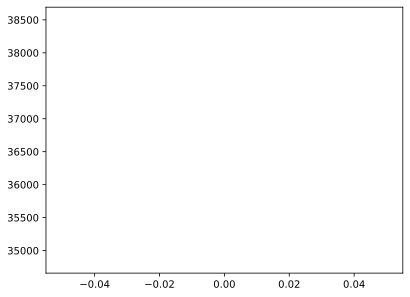

In [18]:
plt.plot(loss_values)
np.savetxt('loss_ABS_TM_128_V2.out', loss_values, delimiter=',')

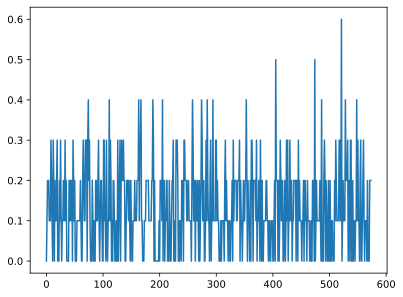

In [19]:
plt.plot(acc)
np.savetxt('acc_TM_128_V2.out', acc, delimiter=',')

## References
https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/course_UvA-DL/11-vision-transformer.ipynb#scrollTo=d8000482
https://github.com/nerminnuraydogan/vision-transformer/blob/main/vision-transformer.ipynb